# Хитрости обучения

## NeuroWorkshop

Дмитрий Сошников | dmitri@soshnikov.com

## Хитрости обучения

 1. Удержание сигналов внутри сети близко к разумному диапазону ($[-1..1]$ или $[0..1]$)

## Масштабирование

Поскольку все активационные функции имеют "интересный" вид в диапазоне $[-1..1]$, то необходимо следить, чтобы сигналы в сети были примерно в этих диапазонах

 * Масштабируем входные/выходные значения в диапазоне $[-1..1]$ или $[0..1]$


## Начальная инициализация весов

 * Нормальное распределение $N(0,1)$ - не хорошо, поскольку если $n$ входов, то на выходе стандартное отклонение $n$
 * Равномерное (`uniform`)
 * $N(0,{1\over n})$ (`gaussian`)
 * $N(0,{1\over \sqrt n_{in}})$ - гарантирует, что для входов с нулевым средним и дисперсией=1, на выходе это свойство сохранится
 * $N(0,{\sqrt{2\over n_{in}+n_{out}}})$ - Xavier initialization (`glorot`), даёт сохранение среднего и дисперсии при обратном распространении

## Batch Normalization

 * Добавление в сеть слоёв, которые осуществляют нормализацию промежуточных результатов в процессе вычисления сети
 * Нормализация осуществляется сразу для всех значений в minibatch (для эффективных вычислений)
 * Существуют другие варианты нормализации (Weight normalization, Layer Normalization)
 * Эффект - ускорение обучения и повышение точности

Источник: [оригинальная статья](https://arxiv.org/pdf/1502.03167.pdf) и [статья на хабре](https://habrahabr.ru/post/309302/)

## Хитрости обучения

 1. Удержание сигналов внутри сети близко к разумному диапазону ($[-1..1]$ или $[0..1]$)
 2. **Возмущения сети за счет выпадения нейронов (Dropout)**

## Dropout

 * При обучении убирать некоторое количество нейронов (10%-30%), чтобы обучение происходило по другим направлениям
 * Достигается внесением специальных слоёв `Dropout(...)`
 * Помогает ускорить обучение
 * Похоже на эффект обучения пьяного
 * Может рассматриваться как неявное усреднение нескольких моделей (implicit model averaging)

## Эффект от Dropout

Посмотрим, как влияет Dropout на модели MNIST

In [31]:
%matplotlib inline
import numpy as np
import cntk
from cntk import Trainer
from cntk.learners import sgd
from cntk.ops import *
from cntk.io import *
from cntk.layers import *
import pylab
import pickle
import os
import matplotlib.pyplot as plt

if not os.path.exists('mnist.pkl'):
    !rm *.pkl
    !wget https://raw.githubusercontent.com/shwars/NeuroWorkshop/master/Data/MNIST/mnist.pkl.gz
    !gzip -d mnist.pkl.gz
        
with open('mnist.pkl', 'rb') as mnist_pickle:
    MNIST = pickle.load(mnist_pickle)
    

In [26]:
features = MNIST['Train']['Features'].astype(np.float32) / 256.0
labels = MNIST['Train']['Labels']
features = features[0:10000]
labels = labels[0:10000]
labels = np.eye(10,dtype=np.float32)[labels]
features = np.reshape(features,(-1,1,28,28))

In [52]:
input_var = input_variable((1,28,28))
label_var = input_variable(10)

model1 = Sequential([
          Convolution((5,5), 9, init=glorot_uniform(),activation=relu, pad=True),
          MaxPooling((3,3), strides=(2,2)),
          Convolution((5,5), 9, init=glorot_uniform(),activation=relu, pad=True),
          MaxPooling((3,3), strides=(2,2)),
          Dense(10, init=glorot_uniform(),activation=None)])

In [ ]:
model2 = Sequential([
          Convolution((5,5), 9, init=glorot_uniform(),activation=relu, pad=True),
          Dropout(0.25),
          MaxPooling((3,3), strides=(2,2)),
          Convolution((5,5), 9, init=glorot_uniform(),activation=relu, pad=True),
          Dropout(0.25),
          MaxPooling((3,3), strides=(2,2)),
          Dropout(0.25),
          Dense(10, init=glorot_uniform(),activation=None)])

In [30]:
def train(model):
    z = model(input_var)
    ce = cntk.cross_entropy_with_softmax(z, label_var)
    pe = cntk.classification_error(z, label_var)    

    minibatch_size = 32

    lr_per_minibatch = cntk.learning_rate_schedule(0.01, cntk.UnitType.minibatch)
    pp = cntk.logging.ProgressPrinter()
    
    learner = cntk.adagrad(z.parameters, lr = lr_per_minibatch)
    trainer = cntk.Trainer(z, (ce, pe), [learner],[pp])

    cntk.logging.log_number_of_parameters(z)
    progress = []
    
    for epoch in range(5):
        perm = np.random.permutation(len(labels))
        taccuracy = 0; tloss = 0; cnt = 0
        for i in range(0, len(labels), minibatch_size):
            max_n = min(i + minibatch_size, len(labels))
            x = features[perm[i:max_n]]
            t = labels[perm[i:max_n]]
            trainer.train_minibatch({input_var:x,label_var:t})
            tloss += trainer.previous_minibatch_loss_average*trainer.previous_minibatch_sample_count
            taccuracy += trainer.previous_minibatch_evaluation_average*trainer.previous_minibatch_sample_count
            cnt+=trainer.previous_minibatch_sample_count
            pp.update_with_trainer(trainer,with_metric=True)
        progress.append([tloss,taccuracy])
        pp.epoch_summary(with_metric=True)
    return progress
    
gr1 = train(model1)
gr2 = train(model2)

Training 5518 parameters in 6 parameter tensors.
Learning rate per minibatch: 0.01
Finished Epoch[1]: loss = 2.319767 * 10000, metric = 87.25% * 10000 5.321s (1879.4 samples/s);
Finished Epoch[2]: loss = 2.277776 * 10000, metric = 83.32% * 10000 5.835s (1713.9 samples/s);
Finished Epoch[3]: loss = 2.199526 * 10000, metric = 67.01% * 10000 5.064s (1974.6 samples/s);
Finished Epoch[4]: loss = 1.406671 * 10000, metric = 36.52% * 10000 4.934s (2026.6 samples/s);
Finished Epoch[5]: loss = 0.430625 * 10000, metric = 11.63% * 10000 5.068s (1973.0 samples/s);
Training 5518 parameters in 6 parameter tensors.
Learning rate per minibatch: 0.01
Finished Epoch[1]: loss = 2.194961 * 10000, metric = 79.27% * 10000 7.539s (1326.4 samples/s);
Finished Epoch[2]: loss = 1.231678 * 10000, metric = 37.03% * 10000 7.950s (1257.9 samples/s);
Finished Epoch[3]: loss = 0.522538 * 10000, metric = 16.42% * 10000 7.210s (1386.9 samples/s);
Finished Epoch[4]: loss = 0.365488 * 10000, metric = 11.23% * 10000 7.309s

In [50]:
def plot_compare(l1,l2):
    p,ax = pylab.subplots(1,2,figsize=(9,3))
    p.suptitle('Normal training vs. Dropout')
    ax[0].plot([[u,v] for ([u,_],[v,_]) in zip(gr1,gr2)])
    ax[0].set_ylabel('Loss')
    ax[1].plot([[u,v] for ([_,u],[_,v]) in zip(gr1,gr2)])
    ax[1].set_ylabel('Accuracy')
    plt.show()

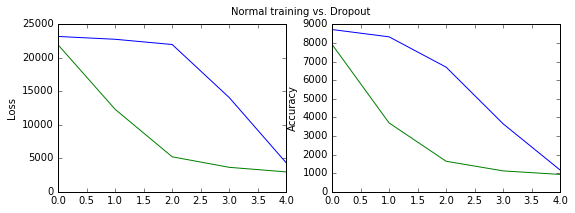

In [51]:
plot_compare(gr1,gr2)

## Хитрости обучения

 1. Удержание сигналов внутри сети близко к разумному диапазону ($[-1..1]$ или $[0..1]$)
 2. Возмущения сети за счет выпадения нейронов (Dropout)
 3. **Вовремя остановиться / избежать переобучения**

## Почему возникает переобучение

  * Недостаточно обучающих данных
  * Слишком богатая нейросеть
  * Слишком зашумлённые входные данные
  
Очень важно соблюсти баланс между выразительностью нейросети (количеством параметров) и количеством независимых обучающих данных

## Как выглядит переобучение

<img src="https://raw.githubusercontent.com/shwars/NeuroWorkshop/master/images/Overfitting.png" width="90%"/>

## Почему так происходит

Ошибка = ошибка аппроксимации + ошибка оценки

 * Ошибка аппроксимации - расстояние между целевой функцией и лучшей аппроксимирующей фунцией в данной архитектуре сети (насколько сеть может приблизить данные точки)
 * Ошибка оценки - ошибка, возникающая из-за того, что мы аппроксимировали не совсем правильну функцию (только на основе только обучающей выборки, а не поняли правильную зависимость в данных

## Разные виды ошибок

 * Ошибка аппроксимации по мере обучения уменьшается (мы приближаем точки обучающей выборки всё лучше)
 * Ошибка оценки возрастает.
 
В зависимости от количества параметров:
 * Для малого количества параметров и большого числа обучающих примеров ошибка аппроксимации большая, ошибка оценки маленькая
 * Для большого количества параметров и малого числа обучающих примеров ошибка аппроксимации маленькая, ошибка оценки большая

## Способы вовремя закончить обучение

 * Явное раннее завершение - откладываем validation set, наблюдаем за validation error, прекращаем, когда она начинает расти
 * Explicit Weight Decay - добавляем к оптимизируемой функции штрафное слагаемое, останавливающее обучение при росте весов
 * Model Averaging - обучаем несколько моделей и берем среднее значение предсказаний
 * Dropout (Implicit Model Averaging)

## Хитрости обучения

 1. Удержание сигналов внутри сети близко к разумному диапазону ($[-1..1]$ или $[0..1]$)
 2. Возмущения сети за счет выпадения нейронов (Dropout)
 3. Вовремя остановиться / избежать переобучения
 4. **Алгоритмы обучения**

## Momentum

 * Stochastic Gradient Descent (SGD)
 $$w^{t+1}=w^t-\eta\nabla\mathcal{L}$$
 
 * Momentum SGD
 $$v^{t+1}=\gamma v^t-\eta\nabla\mathcal{L}\\
   w^{t+1}=w^t+v^{t+1}
 $$
 * $\gamma=0$ - SGD (без памяти), $\gamma=1$ - уравнение движения

## Проблема возрастающих / исчезающих градиентов

На каждом слое происходит умножение на матрицу $W_i$. В зависимости от $||W_i||$, градиент может уменьшиться практически до 0, или неограниченно возрасти.

Решение: Adagrad, RMSProp, Adam

Напр. Adagrad: $w^{t+1}=w^t-\eta\cdot{\nabla\mathcal{L}\over\sqrt\sum(\nabla\mathcal{L})^2}$

## Learning rate decay

Уменьшаем $\eta$ по мере обучения, например, умножая на 0.98

## Gradient clipping

$$\Delta W_{clip} =
  \left\{
  \begin{array}{ll}
  {\Delta W\over ||W||} & \mbox{ если } ||W||\gt\theta\\ 
  \Delta W & \mbox{ в противном случае}
  \end{array}
  \right.
$$
Разумные значения: $\theta=1$ или $\theta=10$

## Хитрости обучения

 1. Удержание сигналов внутри сети близко к разумному диапазону ($[-1..1]$ или $[0..1]$)
 2. Возмущения сети за счет выпадения нейронов (Dropout)
 3. Вовремя остановиться / избежать переобучения
 4. Алгоритмы обучения
 5. **Архитектура сетей**

## Основные способы подбора архитектуры

 1. Взять готовую архитектуру сети, которая себя зарекомендовала для данной задачи ([обзорная статья](https://www.topbots.com/a-brief-history-of-neural-network-architectures/) по архитектурам для изображений)
 2. Попытки научить сеть саму выбирать оптимальную архитектуру

## ResNet

<img src="https://raw.githubusercontent.com/shwars/NeuroWorkshop/master/images/topbots/nnarch10_resnet.jpg" width="40%" align="right"/>
Основная идея ResNet - сеть в начале обучается на небольшом количестве весов/параметров, впоследствии задействуя дополнительные слои по мере необходимости. Для этого сеть строится из большого (50-1000+) числа слоёв такого вида.

Эта архитектура от MSR является победителем ImageNet в 2015 г.



## Inception

<img src="https://raw.githubusercontent.com/shwars/NeuroWorkshop/master/images/topbots/nnarch6_inception.jpg" width="40%" align="right"/>
В данном случае на каждом уровне мы комбинируем несколько возможных "маршрутов" по сети. В результате сеть сама "понимает", каким маршрутом лучше идти, т.е. какой слой оптимален в данном случае.

Прекрасная статья про создания inception-сети на Keras "с нуля" - [тут](https://www.analyticsvidhya.com/blog/2018/10/understanding-inception-network-from-scratch/).

## Мы рассмотрели

 1. Удержание сигналов внутри сети близко к разумному диапазону ($[-1..1]$ или $[0..1]$) и **Batch Normalization**
 2. Возмущения сети за счет выпадения нейронов (**Dropout**)
 3. Критерии остановки обучения и learning rate decay
 4. Алгоритмы обучения: Adagrad, RMSProp, **Adam**
 5. Сети с обучаемой архитектурой: ResNet, Inception